In [1]:
import numpy as np
import pandas as pd 

import os

# Shape of train, val and test should be (nr_samples, 23, 256)
# Every sample of data represents 1 second taken from 23 channels with 256-bit rate
        
npz_file = np.load('./data/eeg-seizure_train.npz', allow_pickle=True)
signals_train = npz_file['train_signals']
labels_train = npz_file['train_labels']

print('Train data shape is {}'.format(signals_train.shape))
print('Labels shape for train is {}'.format(labels_train.shape))

npz_file = np.load('./data/eeg-seizure_val.npz', allow_pickle=True)
signals_val = npz_file['val_signals']
labels_val = npz_file['val_labels']


print('Validation data shape is {}'.format(signals_val.shape))
print('Labels shape for validation is {}'.format(labels_val.shape))

npz_file = np.load('data/eeg-seizure_test.npz', allow_pickle=True)
signals_test = npz_file['test_signals']


print('Test data shape is {}'.format(signals_val.shape))

Train data shape is (37666, 23, 256)
Labels shape for train is (37666,)
Validation data shape is (8071, 23, 256)
Labels shape for validation is (8071,)
Test data shape is (8071, 23, 256)


In [2]:
print(labels_train[0:25])
print(labels_train.min(), labels_train.max())

[1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1]
0 1


In [3]:
print(f'length of the first signal in samples: {signals_train.shape[0]}')

length of the first signal in samples: 37666


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# Load the data from .npz files

nr_samples = signals_train.shape[0]
cases = 23
sampling_rate = 256  # in Hz
time = np.linspace(0, 1, sampling_rate, endpoint=False)  # 1 second of data

# Function to plot EEG signals
def plot_eeg_signals(signals, examples=[0, 1], channels=[0]):
    for i in examples:
        fig = go.Figure()
        for j, channel in enumerate(channels):
            fig.add_trace(go.Scatter(x=time, y=signals[i, channel, :], mode='lines', name=f"Channel {channel}"))
        # Include the label (true, false) in the title
        fig.update_layout(height=600, width=1000, title_text=f"EEG Signal Waveforms for Example {i} – Seizure: {'TRUE' if labels_train[i] == 1 else 'FALSE'}", title_x=0.5, xaxis_title='Time (s)', yaxis_title='Amplitude (µV)')
        fig.show()

# Function to calculate basic statistics
def calculate_statistics(signals):
    means = np.mean(signals, axis=(1, 2))
    variances = np.var(signals, axis=(1, 2))
    return means, variances

# Function to check for missing or corrupted data
def check_data(signals):
    # find channels with zero variance (dead channels which we can interpolate or remove)
    zero_variance_channels = []
    for i in range(signals.shape[0]):
        for j in range(signals.shape[1]):
            if np.var(signals[i, j, :]) == 0:
                #print(f"Channel {j} in example {i} has zero variance.")
                zero_variance_channels.append((i, j))
                
    if not np.all(np.isfinite(signals)):
        print("Data contains non-finite values (inf or nan).")
    if not np.all(np.isreal(signals)):
        print("Data contains complex numbers.")
    if np.any(np.isnan(signals)):
        print("Data contains NaN values.")
    if len(zero_variance_channels) > 0:
        print(f"Data contains channels with zero variance: {zero_variance_channels}")
        print(f'Number of channels with zero variance: {len(zero_variance_channels)}')
        print(f'Average number of channels with zero variance per example: {np.round((len(zero_variance_channels) / signals.shape[0]), 2)}')
    else:
        print("Data is clean.")

# Plot the signals
plot_eeg_signals(signals_train, examples=range(0, 7), channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

# Check data for issues
#check_data(signals_train)


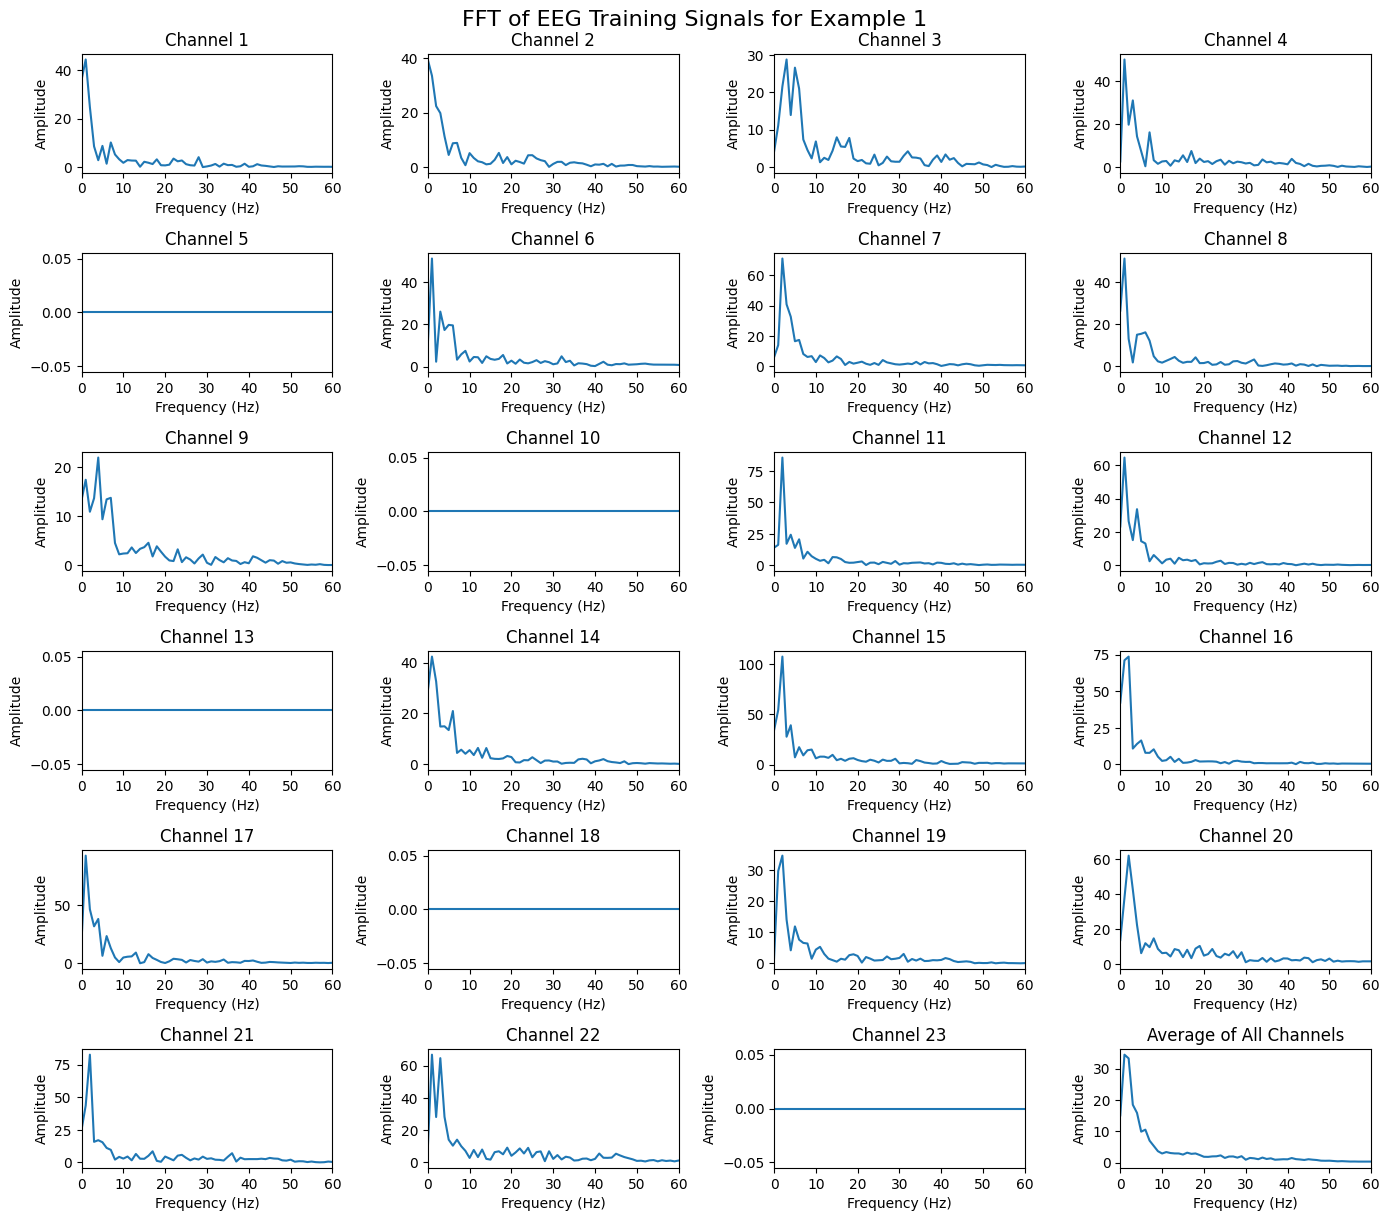

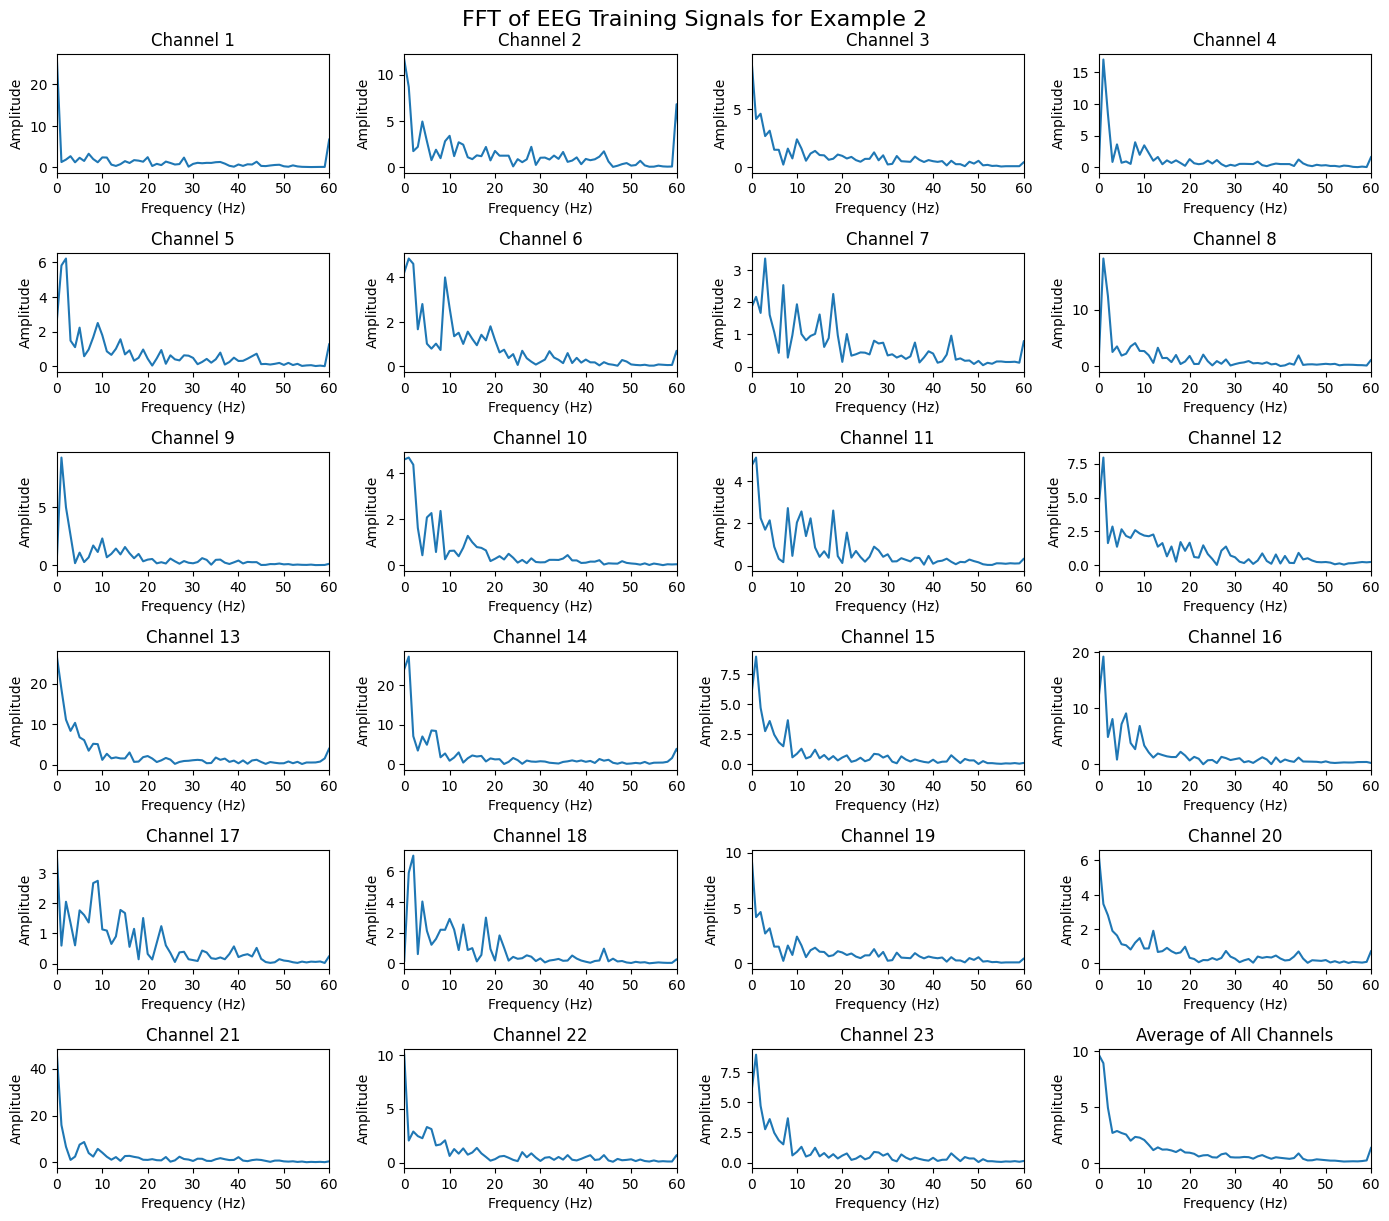

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft


nr_samples = signals_train.shape[0]
cases = 23
sampling_rate = 256  # in Hz
time = np.linspace(0, 1, sampling_rate, endpoint=False)  # 1 second of data

def plot_fft(signals, num_samples=1, show_only_average=False, x_lim_max=60):
     for i in range(num_samples):
          if not show_only_average:
               plt.figure(figsize=(14, 14))
          j = 0
          for ch in range(signals[i].shape[0]):
               # Compute the FFT
               fft_values = fft(signals[i][ch])
               N = len(fft_values)

               # Compute the two-sided spectrum
               P2 = np.abs(fft_values/N)

               # Compute the single-sided spectrum (since the spectrum is symmetric)
               P1 = P2[0:N//2+1]
               P1[1:-1] = 2*P1[1:-1]

               # Define the frequency axis
               f = sampling_rate*np.arange(0,(N//2+1))/N
               if not show_only_average:
                    # Plot the single-sided amplitude spectrum
                    plt.subplot(7, 4, ch+1)
                    plt.plot(f, P1)
                    plt.title(f'Channel {ch+1}')
                    plt.xlabel('Frequency (Hz)')
                    plt.ylabel('Amplitude')
                    plt.xlim([0, x_lim_max])
                    #plt.ylim([0, 0.1])

          # Create an additional subplot for the average of all channels
          avg_fft = np.zeros((N//2+1,))
          for ch in range(signals[i].shape[0]):
               fft_values = fft(signals[i][ch])
               N = len(fft_values)
               P2 = np.abs(fft_values/N)
               P1 = P2[0:N//2+1]
               P1[1:-1] = 2*P1[1:-1]
               avg_fft += P1
          avg_fft /= signals[i].shape[0]
          
          if show_only_average:
               plt.figure(figsize=(6, 2))
          else:
               plt.subplot(7, 4, ch+2)
          
          plt.plot(f, avg_fft)
          plt.title('Average of All Channels')
          plt.xlabel('Frequency (Hz)')
          plt.ylabel('Amplitude')
          plt.xlim([0, x_lim_max])

          if not show_only_average:
               plt.suptitle(f'FFT of EEG Training Signals for Example {i+1}', fontsize=16)
          else:
               plt.title(f'Average FFT of EEG Training Signals for Example {i+1}')
          plt.tight_layout()
          plt.show()



# Plot the FFT
plot_fft(signals_train, 2)

In [6]:
from scipy.interpolate import interp1d

# Identify and interpolate zero-variance channels
def interpolate_zero_variance_channels(signals, verbose=False):
   for i in range(signals.shape[0]):
      for j in range(signals.shape[1]):
         if np.var(signals[i, j, :]) == 0:
            if verbose:
               print(f"Channel {j} in example {i} has zero variance. Interpolating...")

            # Find channels that have non-zero variance
            non_zero_channels = [k for k in range(signals.shape[1]) if np.var(signals[i, k, :]) != 0]

            # If there are no non-zero channels, we can't do interpolation
            if not non_zero_channels:
               if verbose:
                  print(f"No non-zero channels found for example {i}. Cannot interpolate.")
               continue

            # Create an interpolation function based on the non-zero channels
            f = interp1d(non_zero_channels, signals[i, non_zero_channels, :], axis=0, fill_value='extrapolate')

            # Use the interpolation function to estimate the signal for the zero-variance channel
            signals[i, j, :] = f(j)

   return signals

# Interpolate zero-variance channels
inter_signals_train = interpolate_zero_variance_channels(signals_train)


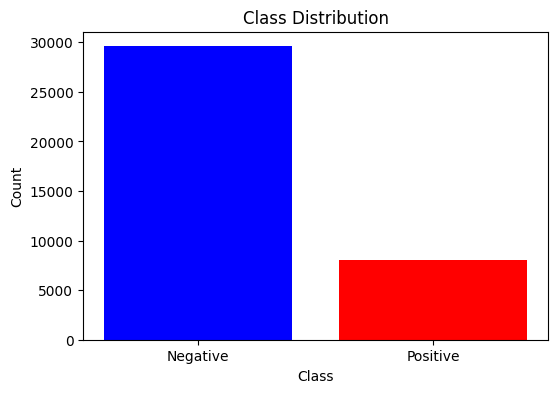

In [7]:
# Show the positive and negative class distribution
def plot_class_distribution(labels):
    # Count the number of positive and negative examples
    unique, counts = np.unique(labels, return_counts=True)
    counts_dict = dict(zip(unique, counts))

    # Convert dictionary keys and values to lists
    keys = list(counts_dict.keys())
    values = list(counts_dict.values())

    # Plot the class distribution
    plt.figure(figsize=(6, 4))
    plt.bar(keys, values, color=['blue', 'red'])
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()

plot_class_distribution(labels_train)

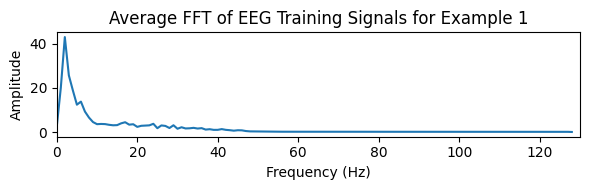

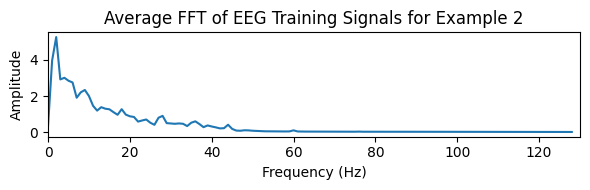

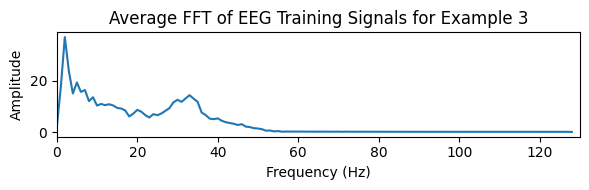

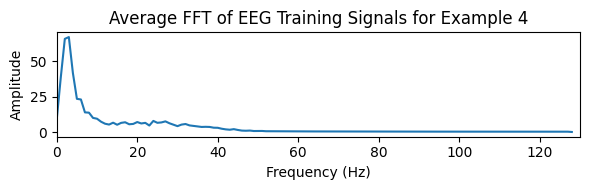

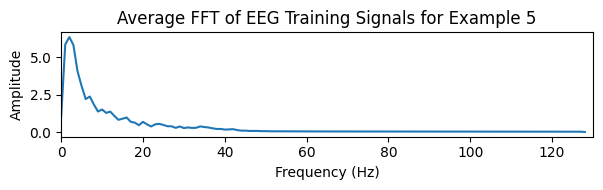

In [8]:
# Implement Butterworth filter 
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def apply_filter(signals, lowcut, highcut, fs):
    filtered_signals = np.zeros(signals.shape)
    for i in range(signals.shape[0]):
        filtered_signals[i] = butter_bandpass_filter(signals[i], lowcut, highcut, fs)
    return filtered_signals
   
# Filter the signals from 1 to 40 Hz
train_filtered = apply_filter(inter_signals_train, 1, 40, sampling_rate)
#plot_eeg_signals(train_filtered)

# Plot the FFT of the filtered signals
plot_fft(train_filtered, 5, True, x_lim_max=130)

In [9]:
print('Train data shape is {}'.format(train_filtered.shape))
print('Labels shape for train is {}'.format(labels_train.shape))
print(f'Length of the first filtered signal is {len(train_filtered[1, 0])}')

Train data shape is (37666, 23, 256)
Labels shape for train is (37666,)
Length of the first filtered signal is 256


In [10]:
# Implement epoching to divide the data into X-ms epochs (we use 1000ms which is the same as the original data)
def epoch_signals(signals, start, end, sample_rate):
      # Calculate the number of samples per epoch
      samples_per_epoch = int((abs(start) + abs(end)) * (sample_rate / 1000))

      # Initialize an empty list to store the epochs
      epochs = []

      # Iterate over the signals
      for signal in signals:
            # Iterate over the channels
            for channel in signal:
                  # Iterate over the channel in steps of samples_per_epoch
                  for i in range(0, len(channel), samples_per_epoch):
                        # Extract the epoch
                        epoch = channel[i:i+samples_per_epoch]

                        # If the epoch is shorter than samples_per_epoch, discard it
                        if len(epoch) < samples_per_epoch:
                              continue

                        # Add the epoch to the list of epochs
                        epochs.append(epoch)

      # Convert the list of epochs to a numpy array and reshape it to match the original data shape
      epochs = np.array(epochs).reshape(len(signals), -1, samples_per_epoch)

      return epochs

start = 0
end = 1000

Several of the false cases have a skewed baseline. Below we will calculate the baseline for each channel for each case and reset the baseline to zero. This will allow the models to better compare the signals.

See https://www.youtube.com/watch?v=zDTsePeDlwo&t=745s for a discussion of the baseline. 

In [11]:
# Create a function to apply baseline correction to the data (skip epoching)

def apply_baseline_correction(signals, baseline_start, baseline_end, sample_rate):
      # Calculate the number of samples per baseline
      samples_per_baseline = int((abs(baseline_start) + abs(baseline_end)) * (sample_rate / 1000))
   
      # Iterate over the signals
      for i in range(signals.shape[0]):
         # Iterate over the channels
         for j in range(signals.shape[1]):
               # Iterate over the channel in steps of samples_per_baseline
               for k in range(0, len(signals[i, j]), samples_per_baseline):
                  # Extract the baseline
                  baseline = signals[i, j, k:k+samples_per_baseline]
   
                  # If the baseline is shorter than samples_per_baseline, discard it
                  if len(baseline) < samples_per_baseline:
                     continue
   
                  # Subtract the mean of the baseline from the signal
                  signals[i, j, k:k+samples_per_baseline] -= np.mean(baseline)
   
      return signals

In [12]:
# No epoching is necessary 
train_corrected = apply_baseline_correction(train_filtered, 0, 100, sampling_rate)

val_inter_signals = interpolate_zero_variance_channels(signals_val, verbose=False)
val_filtered = apply_filter(val_inter_signals, 1, 40, sampling_rate)
val_corrected = apply_baseline_correction(val_filtered, 0, 100, sampling_rate)

test_inter_signals = interpolate_zero_variance_channels(signals_test, verbose=False)
test_filtered = apply_filter(test_inter_signals, 1, 40, sampling_rate)
test_corrected = apply_baseline_correction(test_filtered, 0, 100, sampling_rate)

In [13]:
print('Train data shape is {}'.format(train_corrected.shape))
plot_eeg_signals(train_corrected, examples=range(0, 2), channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

Train data shape is (37666, 23, 256)


In [14]:
# Show the mean range of values for all channels averaged together over all examples
import plotly.graph_objects as go

def plot_mean_range(signals):
    # Create a figure
    fig = go.Figure()
    example_means_true = []
    example_means_false = []

    for i in range(signals.shape[0]):
        # Calculate the mean range of values for all channels
        mean_range = np.mean(np.ptp(signals[i], axis=1))
        if labels_train[i] == 1:
            example_means_true.append(mean_range)
        else:
            example_means_false.append(mean_range)

    trues_mean = np.mean(example_means_true)
    falses_mean = np.mean(example_means_false)

    # Plot the two means a bar chart
    fig.add_trace(go.Bar(x=['True', 'False'], y=[trues_mean, falses_mean], name='Mean Range of Values', marker_color= ['blue', 'red']))    

    # Set the figure layout
    fig.update_layout(
        title='Mean Range of Values for All Channels<br> Averaged Together Over All Examples',
        title_x=0.5,
        xaxis_title='True and False Examples',
        yaxis_title='Mean Range of Values',
        barmode='group',
        width=400,
        height=400
    )

    # Show the figure
    fig.show()

plot_mean_range(train_corrected)

The above chart demonstrates that perhaps large value ranges (transients) are actual seizure-predictive features. However, they could also be blinking or other movement artifacts, and the real range of the signals is much smaller (closer to the range of the negative cases).

In [15]:
# Implement a function to remove channels with extreme values (e.g. > 1000 µV)
def remove_extreme_channels(signals, threshold):
    # Iterate over the signals
    for i in range(signals.shape[0]):
        # Iterate over the channels
        for j in range(signals.shape[1]):
            # If the channel has an extreme value, set it to zero
            if np.max(np.abs(signals[i, j])) > threshold:
                signals[i, j] = range(signals[i, j].shape[0])

    return signals

# Remove channels with extreme values
#train_cleaned = remove_extreme_channels(train_corrected, 300)

# Interpolate zero-variance channels
#train_cleaned = interpolate_zero_variance_channels(train_cleaned)

In [16]:
# Implement a function to sum the channels together
def average_channels(signals):
      # Sum the channels together
      summed_signals = np.sum(signals, axis=1)
   
      return summed_signals

# Average the channels together
#train_averaged = average_channels(train_corrected)
#val_averaged = average_channels(val_corrected)
#test_averaged = average_channels(test_corrected)
   

So far, epoching, summing channels, and interpolating extreme channels have not improved the accuracy of our model.

However, interpolating missing channels, filtering at 40Hz, and doing baseline correction between 0 and 100 samples have improved the accuracy of our model.

XDAWN was not applied to the averaged channels for obvious reasons, but it has been applied to all other techniques.

Below we are implementing XDAWN covariance matrix estimation. We will use the XDAWN algorithm to estimate the covariance matrix of the data to reduce dimensionality, training the classifier on the matrix as opposed to the raw data.

In [17]:
from pyriemann.estimation import XdawnCovariances

# Initialize the XdawnCovariances object
xdawn = XdawnCovariances(nfilter=5, applyfilters=False)  # nfilter is the number of spatial filters

xdawn.fit(train_corrected, labels_train) 

train_xdawn = xdawn.transform(train_corrected)
val_xdawn = xdawn.transform(val_corrected)
test_xdawn = xdawn.transform(test_corrected)

# *_xdawn now contain the XDAWN covariance matrices for each epoch per dataset

In [18]:
# Rename the training and validation sets
X_train, X_test, y_train, y_test = train_xdawn, val_xdawn, labels_train, labels_val

# Reshape the XDAWN covariance matrices into a 2D array for the classifier
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
test_2D = test_xdawn.reshape(test_xdawn.shape[0], -1)
print('XDAWN train 2D shape:', X_train_2d.shape)

# Combine the training and validation sets
X_train_all = np.vstack((X_train_2d, X_test_2d))
y_train_all = np.hstack((y_train, y_test))

XDAWN train 2D shape: (37666, 1089)


In [ ]:
# Implement XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBClassifier
xgb = XGBClassifier(objective='binary:logistic',
                  n_estimators=600,
                  max_depth=None,
                  learning_rate=0.15,
                  min_child_weight=1,
                  subsample=1,
                  colsample_bytree=1,
                  reg_alpha=0,
                  reg_lambda=1,
                  gamma=0,
                  eval_metric='logloss',
                  use_label_encoder=False,
                  random_state=42, n_jobs=-1, verbosity=1)

# Fit the classifier to the training data
xgb.fit(X_train_2d, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test_2d)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100}%")

# Print the classification report
print(classification_report(y_test, y_pred))

In [ ]:
# Implement LGBM 
from lightgbm import LGBMClassifier

# Initialize the LGBMClassifier
lgbm = LGBMClassifier(
      n_estimators=1700,
      max_depth=None,
      learning_rate=0.15,
      min_child_weight=1,
      subsample=1,
      colsample_bytree=1,
      reg_alpha=0,
      reg_lambda=1,
      objective='binary', 
      is_unbalance=True,
      random_state=42,
      n_jobs=-1,
      verbosity=1)

# Fit the classifier to the training data
lgbm.fit(X_train_2d, y_train)

# Make predictions on the test data
y_pred = lgbm.predict(X_test_2d)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100}%")

# Print the classification report
print(classification_report(y_test, y_pred))

In [ ]:
# Implement Random Forest
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=800,
                            max_features=60,
                            max_depth=25,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            bootstrap=True,
                            random_state=42, n_jobs=-1)

# Fit the classifier to the training data
rf.fit(X_train_2d, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test_2d)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100}%")

# Print the classification report
print(classification_report(y_test, y_pred))

In [ ]:
xgb = xgb.fit(X_train_all, y_train_all)
lgbm = lgbm.fit(X_train_all, y_train_all)
#rf = rf.fit(X_train_all, y_train_all)

In [ ]:
# Implement CalibratedClassifierCV to calibrate the models
from sklearn.calibration import CalibratedClassifierCV

# Initialize the CalibratedClassifierCVs
calibrated_xgb = CalibratedClassifierCV(xgb, method='isotonic', cv="prefit", ensemble=False)
calibrated_lgbm = CalibratedClassifierCV(lgbm, method='isotonic', cv="prefit", ensemble=False)
#calibrated_rf = CalibratedClassifierCV(rf, method='isotonic', cv="prefit", ensemble=False)

# Fit the calibrated classifier to the training data
calibrated_xgb.fit(X_test_2d, y_test)
calibrated_lgbm.fit(X_test_2d, y_test)
#calibrated_rf.fit(X_test_2d, y_test)

In [ ]:
# Implement a soft voting classifier with the xgb and random forest classifiers
from sklearn.ensemble import VotingClassifier

# Initialize the full_set VotingClassifier
'''
full_set_voting = VotingClassifier(
   estimators=[
      ('xgb', calibrated_xgb),
      ('lgbm', calibrated_lgbm),
      ('rf', calibrated_rf)
      ], 
   voting='soft', n_jobs=-1)
'''

xgb_lgb_voting = VotingClassifier(
   estimators=[
      ('xgb', xgb),
      ('lgbm', lgbm)
      ], 
   voting='soft', n_jobs=-1)


# Fit the VotingClassifier to the training data
#full_set_voting.fit(X_train_all, y_train_all) # We are no longer using the random forest classifier
xgb_lgb_voting.fit(X_train_all, y_train_all)



In [ ]:
y_pred = xgb_lgb_voting.predict(test_2D)

df = pd.DataFrame(y_pred, columns=['Predicted'])
df.index.name = 'id'
filename = input('Enter the name for the predictions:')
#filename = 'xgb_tuned_v2__1E1000_B40'
df.to_csv(f'predictions/{filename}.csv', header=True)

In [ ]:
# Implement a stacking classifier with the soft voting classifiers as the base estimators and the xgb classifier as the final estimator
from sklearn.ensemble import StackingClassifier

# Initialize the StackingClassifier
stacking = StackingClassifier(
   estimators=[
      ('full_set_voting', full_set_voting),
      ('xgb_lgb_voting', xgb_lgb_voting)
      ], 
   final_estimator=xgb, 
   n_jobs=-1)

# Fit the StackingClassifier to the training data
stacking.fit(X_train_all, y_train_all)

# Make predictions on the test data
y_pred_stacking = stacking.predict(test_2D)

df = pd.DataFrame(y_pred_stacking, columns=['Predicted'])
df.index.name = 'id'
filename = input('Enter the name for the predictions:')
#filename = 'xgb_tuned_v2__1E1000_B40'
df.to_csv(f'/predictions/{filename}.csv', header=True)

In [ ]:
# Fit the VotingClassifier on all the data
full_set_voting.fit(X_train_all, y_train_all)

# Make predictions on the test data
y_pred = full_set_voting.predict(test_2D)

df = pd.DataFrame(y_pred, columns=['Predicted'])
df.index.name = 'id'
filename = input('Enter the name for the predictions:')
#filename = 'xgb_tuned_v2__1E1000_B40'
df.to_csv(f'/predictions/{filename}.csv', header=True)

In [ ]:
import tensorflow as tf
from keras import models, layers, optimizers, regularizers, callbacks, Model 

# Create a simple neural network base_model with no regularization as a baseline
base = models.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train_2d.shape[1],), name='Dense_1'),
    layers.Dense(128, activation='relu', name='Dense_2'),
    layers.Dense(64, activation='relu', name='Dense_3'),
    layers.Dense(1, activation='sigmoid', name='Output')
])

# Compile the base_model
base.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

cnn = models.Sequential([
    layers.Input(shape=(X_train_2d.shape[1],), name='Input'),
    layers.Reshape((-1, 1), name='Reshape'),  # Reshape the input to be 3D
    layers.Conv1D(16, 3, activation='relu', kernel_initializer='he_normal', name='Conv1D_1'),
    layers.BatchNormalization(name='BatchNorm_1'),
    layers.MaxPooling1D(2, name='MaxPool_1'),
    layers.Dropout(0.5, name='Dropout_1'),
    layers.Conv1D(32, 3, activation='relu', kernel_initializer='he_normal', name='Conv1D_2'),
    layers.BatchNormalization(name='BatchNorm_2'),
    layers.MaxPooling1D(2, name='MaxPool_2'),
    layers.Dropout(0.5, name='Dropout_2'),
    layers.Conv1D(64, 3, activation='relu', kernel_initializer='he_normal', name='Conv1D_3'),
    layers.BatchNormalization(name='BatchNorm_3'),
    layers.MaxPooling1D(2, name='MaxPool_3'),
    layers.Conv1D(128, 3, activation='relu', kernel_initializer='he_normal', name='Conv1D_4'),
    layers.BatchNormalization(name='BatchNorm_4'),
    layers.MaxPooling1D(2, name='MaxPool_4'),
    layers.Flatten(name='Flatten'),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal', name='Dense_1'),
    layers.BatchNormalization(name='BatchNorm_5'),
    layers.Dropout(0.5, name='Dropout_3'),
    layers.Dense(1, activation='sigmoid', name='Output')
])

# Compile the model
cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Create a deep and wide neural network model
deep_sequential = models.Sequential([
    layers.Input(shape=(X_train_2d.shape[1],), name='Input'),
    layers.Dense(2048, activation='relu', kernel_initializer='he_normal', name='Dense_1'),
    layers.BatchNormalization(name='BatchNorm_1'),
    layers.Dropout(0.5, name='Dropout_1'),
    layers.Dense(1024, activation='relu', kernel_initializer='he_normal', name='Dense_2'),
    layers.BatchNormalization(name='BatchNorm_2'),
    layers.Dropout(0.5, name='Dropout_2'),
    layers.Dense(512, activation='relu', kernel_initializer='he_normal', name='Dense_3'),
    layers.BatchNormalization(name='BatchNorm_3'),
    layers.Dropout(0.5, name='Dropout_3'),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal', name='Dense_4'),
    layers.BatchNormalization(name='BatchNorm_4'),
    layers.Dropout(0.5, name='Dropout_4'),
    layers.Dense(128, activation='relu', kernel_initializer='he_normal', name='Dense_5'),
    layers.BatchNormalization(name='BatchNorm_5'),
    layers.Dropout(0.5, name='Dropout_5'),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='Dense_6'),
    layers.BatchNormalization(name='BatchNorm_6'),
    layers.Dropout(0.5, name='Dropout_6'),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal', name='Dense_7'),
    layers.BatchNormalization(name='BatchNorm_7'),
    layers.Dropout(0.5, name='Dropout_7'),
    layers.Dense(1, activation='sigmoid', name='Output')
])

# Compile the model
deep_sequential.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

input_ = layers.Input(shape=X_train_2d.shape[1]) 
# Define the layers
normalizer = layers.Normalization()
normalizer.adapt(X_train_2d)
normalization_layer = normalizer(input_)
hidden_layer1 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_1')(normalization_layer)
dropout1 = layers.Dropout(0.5)(hidden_layer1)
batch_norm_1 = layers.BatchNormalization()(dropout1)
hidden_layer2 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_2')(batch_norm_1)
dropout2 = layers.Dropout(0.5)(hidden_layer2)
batch_norm_2 = layers.BatchNormalization()(dropout2)
hidden_layer3 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_3')(batch_norm_2)
dropout3 = layers.Dropout(0.5)(hidden_layer3)
batch_norm_3 = layers.BatchNormalization()(dropout3)
hidden_layer4 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_4')(batch_norm_3)
dropout4 = layers.Dropout(0.5)(hidden_layer4)
batch_norm_4 = layers.BatchNormalization()(dropout4)
hidden_layer5 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_5')(batch_norm_4)
dropout5 = layers.Dropout(0.25)(hidden_layer5)
batch_norm_5 = layers.BatchNormalization()(dropout5)
hidden_layer6 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_6')(batch_norm_5)
dropout6 = layers.Dropout(0.25)(hidden_layer6)
batch_norm_6 = layers.BatchNormalization()(dropout6)
hidden_layer7 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_7')(batch_norm_6)
dropout7 = layers.Dropout(0.25)(hidden_layer7)
batch_norm_7 = layers.BatchNormalization()(dropout7)
hidden_layer8 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_8')(batch_norm_7)
dropout8 = layers.Dropout(0.5)(hidden_layer8)
batch_norm_8 = layers.BatchNormalization()(dropout8)
hidden_layer9 = layers.Dense(32, activation="relu", kernel_initializer='he_normal', name='Dense_9')(batch_norm_8)
dropout9 = layers.Dropout(0.5)(hidden_layer9)

concat_layer = layers.Concatenate()
concat_layer = concat_layer([normalization_layer, dropout6])
output_layer = layers.Dense(1)(concat_layer)

# Define the model
model = Model(inputs=[input_], outputs=[output_layer])

# Define the model
deep_and_wide = Model(inputs=[input_], outputs=[output_layer], name='deep_and_wide')

# Define a binary weight dictionary to assign a higher weight to the positive class
class_weight = {0: 1, 1: 5}

# Compile the model
deep_and_wide.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'],
            sample_weight_mode='temporal',
        )

# Print the summary of the models
#print('Base model summary:')
#base.summary()

#print('CNN model summary:')
#cnn.summary()

#print('Deep sequential summary:')
#deep_sequential.summary()

print('Deep and Wide summary:')
deep_and_wide.summary()

# Implement early stopping, tensorboard callbacks, and a learning rate scheduler
early_stopping = callbacks.EarlyStopping(
    monitor='val_accuracy', # what to monitor
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

tensorboard_callback = callbacks.TensorBoard(
    log_dir='logs', 
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None

)

lr_scheduler = callbacks.ReduceLROnPlateau(
   monitor='val_accuracy',
   factor=0.1, 
   patience=3,
   verbose=1,
   min_lr=0.001)


In [ ]:
# Assume we have 1000 samples and 10 time steps
num_samples = 37666


# Get the number of true and false samples
num_true_samples = np.sum(y_train)
num_false_samples = num_samples - num_true_samples

# We'll give a higher weight to the first half of the samples
sample_weight = np.zeros(num_samples)
for i in range(num_samples):
    if y_train[i] == 1:
        sample_weight[i] = 1

# Train the deep_and_wide model
deep_and_wide_history = deep_and_wide.fit(X_train_2d, y_train, 
                        validation_data=(X_test_2d y_test), 
                        epochs=100, 
                        shuffle=False,
                        steps_per_epoch=X_train_2d.shape[0] // 16,
                        validation_steps=X_test_2d.shape[0] // 16,
                        batch_size=16, 
                        sample_weight=sample_weight,
                        callbacks=[tensorboard_callback, early_stopping, lr_scheduler])
# Evaluate the deep_and_wide model
deep_and_wide_accuracy = deep_and_wide.evaluate(X_test_2d, y_test)[1]
print(f"Deep and wide model accuracy: {deep_and_wide_accuracy * 100}%")

In [ ]:
# Import EEGNet
from EEGModels import EEGNet

# Initialize the EEGNet model
eegnet = EEGNet(nb_classes=1, Chans=23, Samples=256, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')

# Compile the model
eegnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
eegnet_history = eegnet.fit(X_train_2d, y_train, 
                        validation_data=(X_test_2d, y_test), 
                        epochs=100, 
                        shuffle=False,
                        steps_per_epoch=X_train_2d.shape[0] // 16,
                        validation_steps=X_test_2d.shape[0] // 16,
                        batch_size=16, 
                        sample_weight=sample_weight,
                        callbacks=[tensorboard_callback, early_stopping, lr_scheduler])

In [ ]:
# Load tensorboard
%tensorboard --logdir logs
# Clear any logs from previous runs
!rm -rf logs


# Train the base_model
base_history = base.fit(X_train_2d, y_train, 
                        validation_data=(X_test_2d, y_test), 
                        epochs=100, 
                        shuffle=True,
                        steps_per_epoch=X_train_2d.shape[0] // 16,
                        validation_steps=X_test_2d.shape[0] // 16,
                        batch_size=16, 
                        callbacks=[tensorboard_callback, early_stopping, lr_scheduler])
# Evaluate the base_model
base_accuracy = base.evaluate(X_test_2d, y_test)[1]
print(f"Base model accuracy: {base_accuracy * 100}%")

# Train the model_cnn
cnn_history = cnn.fit(X_train_2d, y_train, 
                        validation_data=(X_test_2d, y_test), 
                        epochs=100, 
                        shuffle=True,
                        steps_per_epoch=X_train_2d.shape[0] // 16,
                        validation_steps=X_test_2d.shape[0] // 16,
                        batch_size=16, 
                        callbacks=[tensorboard_callback, early_stopping, lr_scheduler])
# Evaluate the model_cnn
cnn_accuracy = cnn.evaluate(X_test_2d, y_test)[1]
print(f"CNN model accuracy: {cnn_accuracy * 100}%")

# Train the model_deep_sequential
deep_sequential_history = deep_sequential.fit(X_train_2d, y_train, 
                        validation_data=(X_test_2d, y_test), 
                        epochs=100, 
                        shuffle=True,
                        steps_per_epoch=X_train_2d.shape[0] // 16,
                        validation_steps=X_test_2d.shape[0] // 16,
                        batch_size=16, 
                        callbacks=[tensorboard_callback, early_stopping, lr_scheduler])
# Evaluate the model_deep_sequential
deep_sequential_accuracy = deep_sequential.evaluate(X_test_2d, y_test)[1]
print(f"Deep and wide model accuracy: {deep_sequential_accuracy * 100}%")

# Train the deep_and_wide model
deep_and_wide_history = deep_and_wide.fit(X_train_2d, y_train, 
                        validation_data=(X_test_2d, y_test), 
                        epochs=100, 
                        shuffle=True,
                        steps_per_epoch=X_train_2d.shape[0] // 16,
                        validation_steps=X_test_2d.shape[0] // 16,
                        batch_size=16, 
                        callbacks=[tensorboard_callback, early_stopping, lr_scheduler])
# Evaluate the deep_and_wide model
deep_and_wide_accuracy = deep_and_wide.evaluate(X_test_2d, y_test)[1]
print(f"Deep and wide model accuracy: {deep_and_wide_accuracy * 100}%")


In [ ]:
# Plot the training histories for the base_model, model_cnn, and model_deep_wide superimposed
import plotly.graph_objects as go

# Create traces
trace0 = go.Scatter(
   x=list(range(len(base_history.history['base_accuracy']))),
   y=base_history.history['base_accuracy'],
   mode='lines',
   name='Base Model'
)

trace1 = go.Scatter(
   x=list(range(len(cnn_history.history['base_accuracy']))),
   y=cnn_history.history['base_accuracy'],
   mode='lines',
   name='CNN Model'
)

trace2 = go.Scatter(
   x=list(range(len(deep_sequential_history.history['base_accuracy']))),
   y=deep_sequential_history.history['base_accuracy'],
   mode='lines',
   name='Deep Sequential Model'
)

trace3 = go.Scatter(
   x=list(range(len(deep_and_wide_history.history['base_accuracy']))),
   y=deep_and_wide_history.history['base_accuracy'],
   mode='lines',
   name='Deep and Wide Model'
)

data = [trace0, trace1, trace2, trace3]

# Define layout
layout = go.Layout(
   title='Training History',
   xaxis=dict(title='Epoch'),
   yaxis=dict(title='Accuracy'),
)

# Define figure and add data and layout
fig = go.Figure(data=data, layout=layout)

# Show plot
fig.show()

In [ ]:
# Train the three models on all the data
base.fit(X_train_all, y_train_all)
cnn.fit(X_train_all, y_train_all)
deep_sequential.fit(X_train_all, y_train_all)

In [ ]:
# Predict the test data
y_pred_base = base.predict(test_2D)
y_pred_cnn = cnn.predict(test_2D)
y_pred_deep_wide = deep_sequential.predict(test_2D)

# Convert the predictions to binary
y_pred_base = np.round(y_pred_base).astype(int)
y_pred_cnn = np.round(y_pred_cnn).astype(int)
y_pred_deep_wide = np.round(y_pred_deep_wide).astype(int)

# Save the predictions to a CSV file using pandas
df = pd.DataFrame(y_pred_base, columns=['Predicted'])
df.index.name = 'id'
filename = input('Enter the name for the predictions:')
df.to_csv(f'{filename}.csv', header=True)

df = pd.DataFrame(y_pred_cnn, columns=['Predicted'])
df.index.name = 'id'
filename = input('Enter the name for the predictions:')
df.to_csv(f'{filename}.csv', header=True)

df = pd.DataFrame(y_pred_deep_wide, columns=['Predicted'])
df.index.name = 'id'
filename = input('Enter the name for the predictions:')
df.to_csv(f'{filename}.csv', header=True)

## Report

The sequential shallow model performed much worse than the deep and wide model as it is significantly underfitting the data. Even without regularization, the shallow model simply cannot capture such varied features. I also included a CNN to test that as well; it has a similar depth to the deep and wide model, but fewer trainable parameters (2,197,729 vs. 5,046,145, respectively). It performed almost as well as the deep and wide model, achieving a validation score of 90.80% vs. 93.10%, respectively, but plateaued earlier due to underfitting and was stopped by Early Stopping. 

We employed Dropout and L2 regularization to prevent overfitting on both the CNN and the deep and wide model, which helped us gain about 1% in validation accuracy. We also used Batch Normalization to speed up training and improve the model's performance.

![training history.png](<attachment:training history.png>)
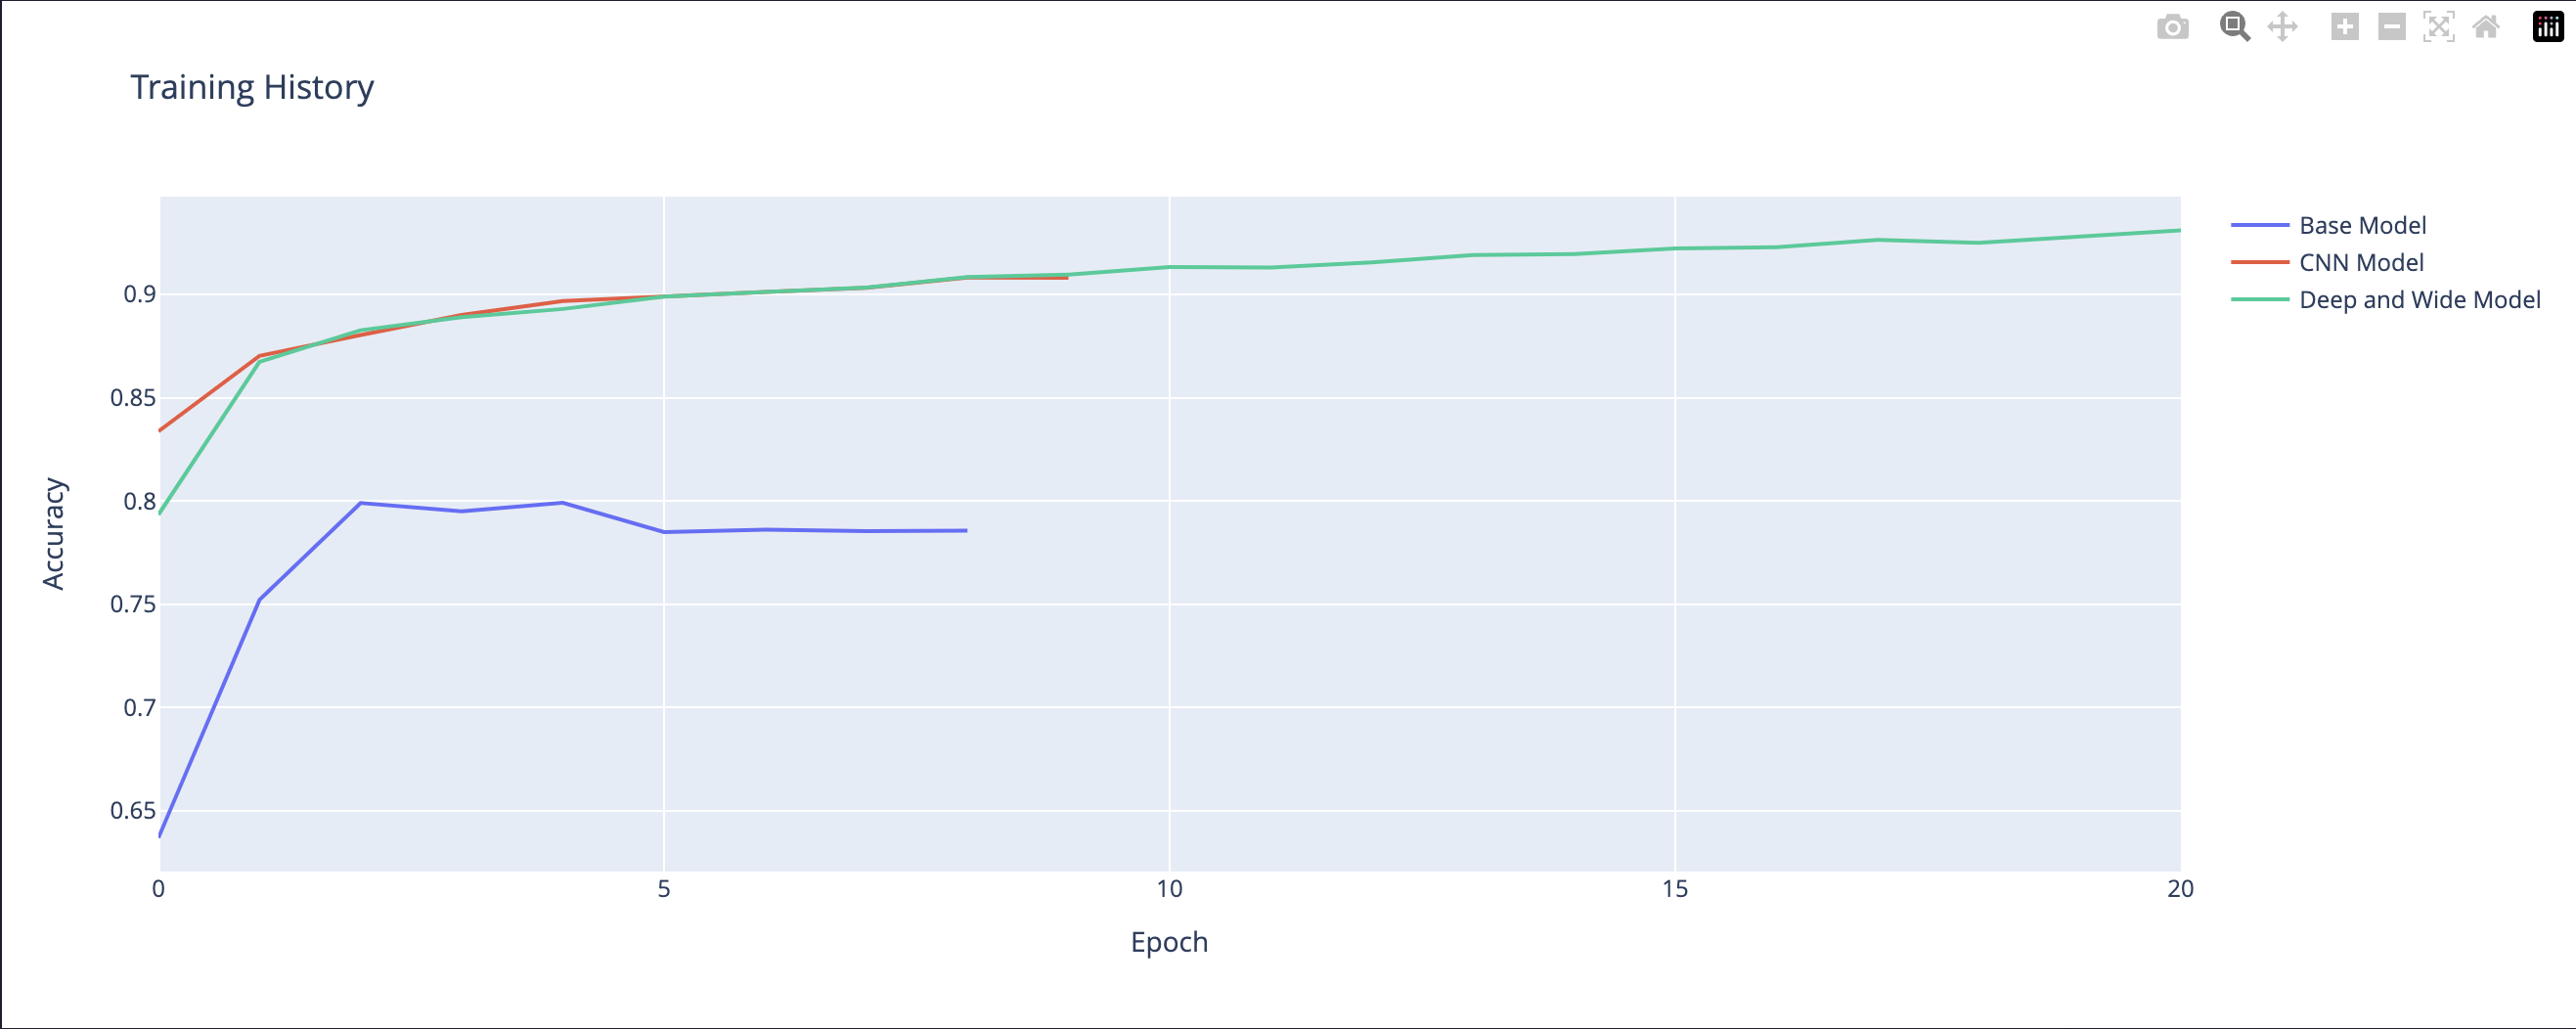